In [1]:
# Imports
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
import shapely
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import os
import sys
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import MousePosition, ScrollZoomToggler, HeatMap
import pysal.lib.weights as sw # create spatial weights matrix
from pysal.explore.esda import Moran, Moran_Local #global & local Moran's I
from pysal.model import spreg #spatial regression module
from pysal.viz.splot.esda import lisa_cluster, plot_local_autocorrelation
# Spatial hex bin tools
import h3
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate

# Suppress warnings and adjust settings
import warnings
warnings.filterwarnings('ignore') # Suppress Jupyter Notebook warnings
from IPython.core.display import display, HTML # Set HTML notebooks to max width
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 250)

# Input path to tax_project folder here
os.chdir("F:\\Assignments\\INST490\\tax_project\\")

"Load Complete"

C:\Users\Impul\.conda\envs\geo-ds\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Impul\.conda\envs\geo-ds\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


'Load Complete'

In [2]:
# Spatially referenced dataset
geo_processed = gpd.read_file(r"maryland_tax_valuations\data\processed\appeals_sf.geojson")
geo = geo_processed[['account.number', 'appealed.value', 'final.value', 'value.change', 'pct_change', 'match_address', 'census_tract', 'census_block', 'type_change', 'geometry']]
geo.loc[geo['final.value'] == 'NULL', 'final.value'] = 0
geo['final.value'] = geo['final.value'].astype(int)

# MD census tracts + census data
md_tracts = gpd.read_file("https://opendata.arcgis.com/datasets/bbe7d09a81fc40c8a7c9f4c80155842e_0.geojson")
# MD binned into spatially uniform hex bins
md_hex = gpd.read_file(r"maryland_tax_valuations\data\md_hex_bins.shp")

"Load Complete"

'Load Complete'

In [4]:
geo.head()

,account.number,appealed.value,final.value,value.change,pct_change,match_address,census_tract,census_block,type_change,geometry
0,0116009105,171300,163700,-7600,4.4,12501 GOLDENS AVE CUMBERLAND,000200,3010,Decrease,POINT (-78.73335 39.60901)
1,0116009784,115700,55500,-60200,52.0,12301 PINEY FLATS RD CUMBERLAND,000200,1025,Decrease,POINT (-78.69448 39.62848)
2,0121002194,98000,98000,0,-0.0,14406 BALTIMORE PIKE CUMBERLAND,000200,2019,None,POINT (-78.70073 39.67919)
3,0121002208,54300,36600,-17700,32.6,14400 BALTIMORE PIKE CUMBERLAND,000200,2019,Decrease,POINT (-78.70181 39.67930)
4,0121002224,77800,53200,-24600,31.6,14400 BALTIMORE PIKE CUMBERLAND,000200,2019,Decrease,POINT (-78.70181 39.67930)


## INITIAL PLOTS

Text(0.5, 0.98, '% change plotted over MD census tracts')

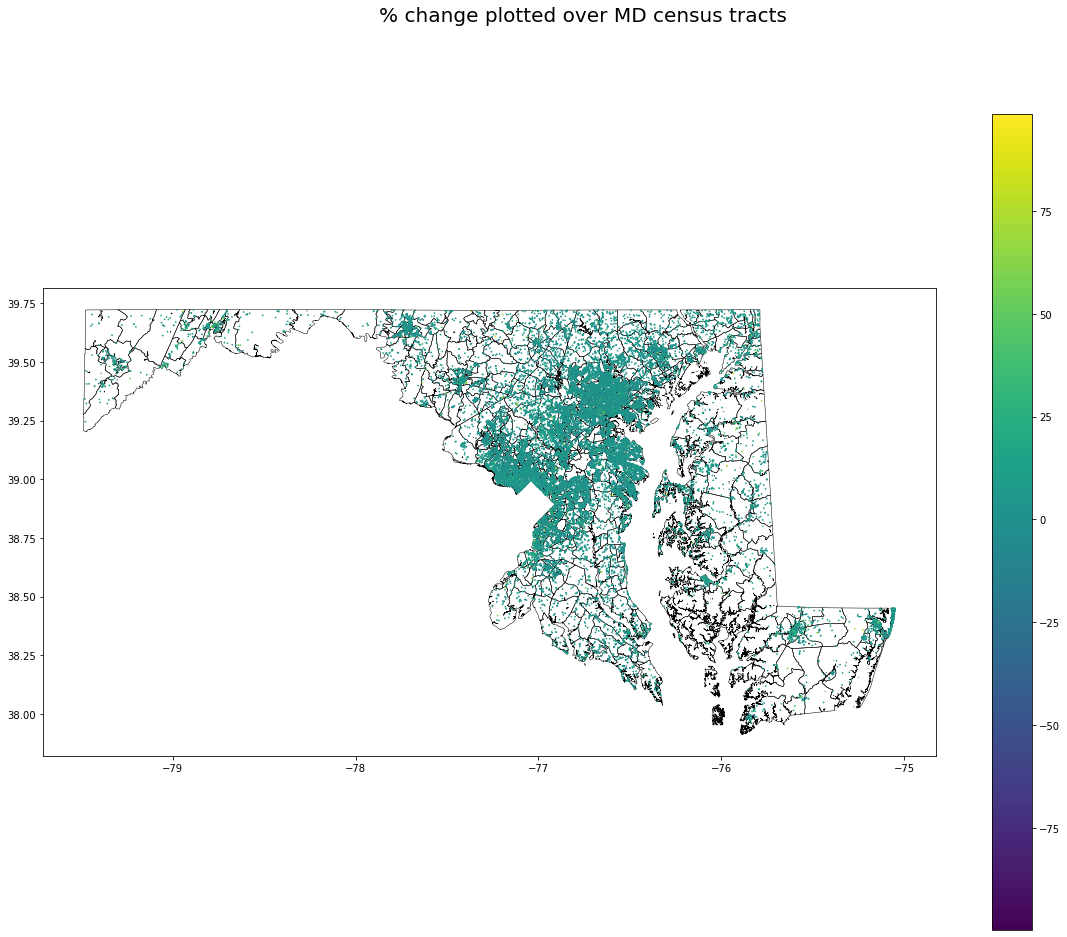

In [13]:
# Overall situation
fig, ax = plt.subplots(figsize=(20,15))
md_tracts.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.5)
# Filtering out rows that have > 100% change in appraisal value, + or -
geoprocessed_mask = ((geo_processed['pct_change'] < 100.0) & (geo_processed['pct_change'] > -100.0)) #  & (joined['pct_change'] != 0.0)
geoprocessed_filter = geo[geoprocessed_mask]
geoprocessed_filter.plot('pct_change', markersize=0.5, ax=ax, legend=True)
fig.suptitle("% change plotted over MD census tracts", fontsize=20)

Text(0.5, 0.98, 'Positive % change plotted over MD census tracts')

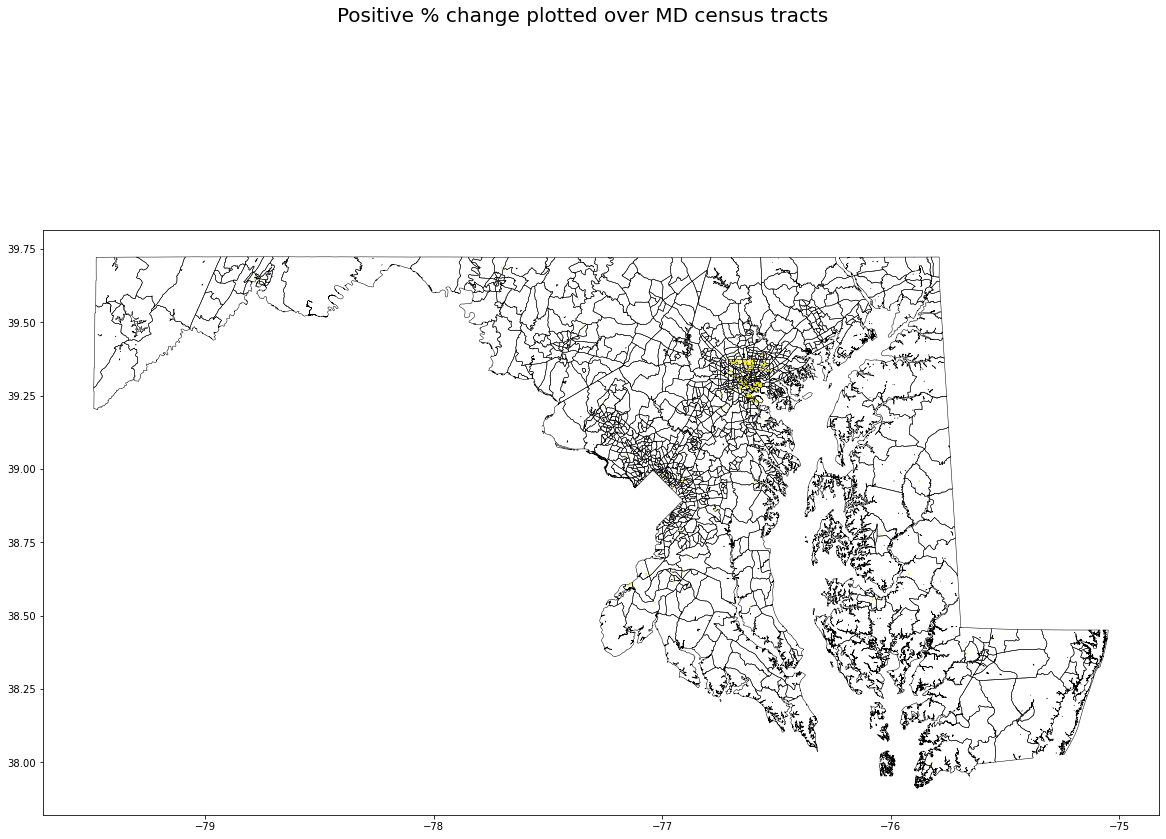

In [8]:
# Positive change
fig, ax = plt.subplots(figsize=(20,15))
md_tracts.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.5)
geo_mask = (geo['final.value'] > geo['appealed.value'])
geo_filter = geo[geo_mask]
geo_filter.plot('pct_change', markersize=0.5, ax=ax, legend=False)
fig.suptitle("Positive % change plotted over MD census tracts", fontsize=20)

Text(0.5, 0.98, 'Negative % change plotted over MD census tracts')

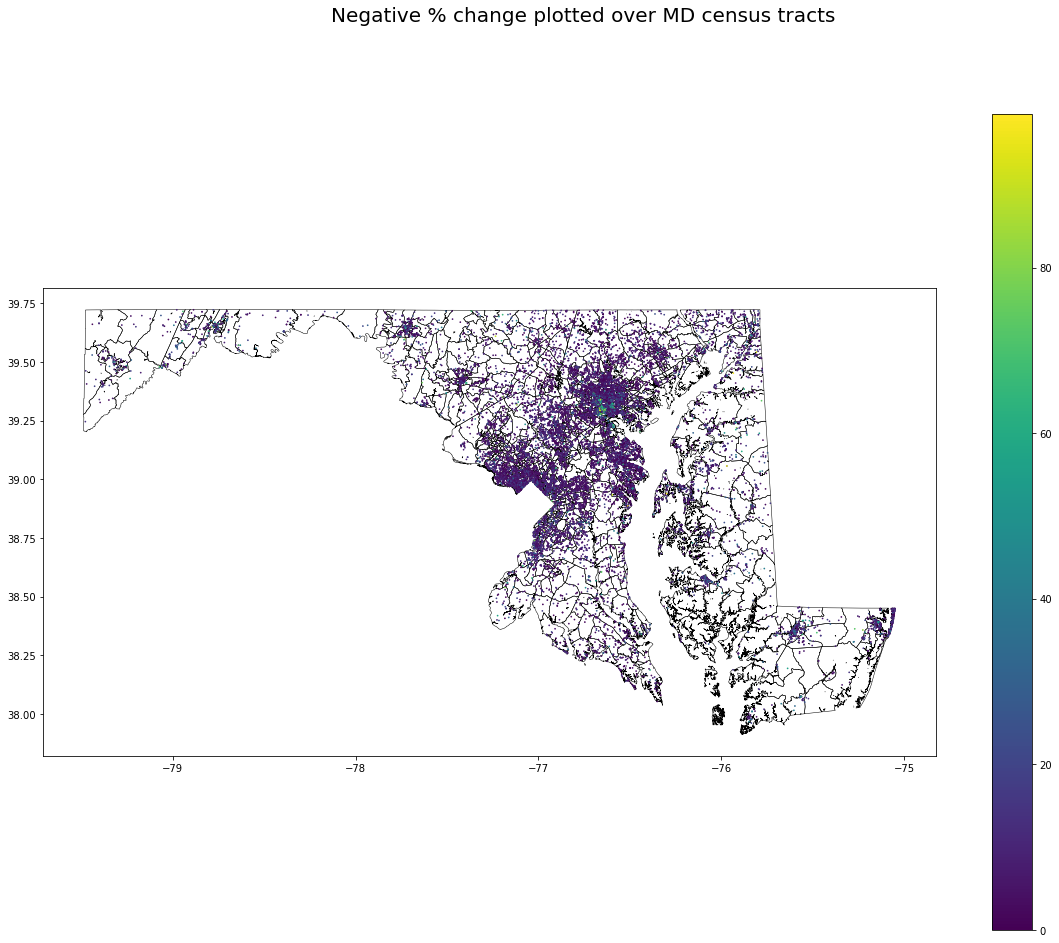

In [10]:
# Negative change
fig, ax = plt.subplots(figsize=(20,15))
md_tracts.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.5)
geo_mask = (geo['final.value'] < geo['appealed.value'])
geo_filter = geo[geo_mask]
geo_filter.plot('pct_change', markersize=0.5, ax=ax, legend=True)
fig.suptitle("Negative % change plotted over MD census tracts", fontsize=20)

<AxesSubplot:>

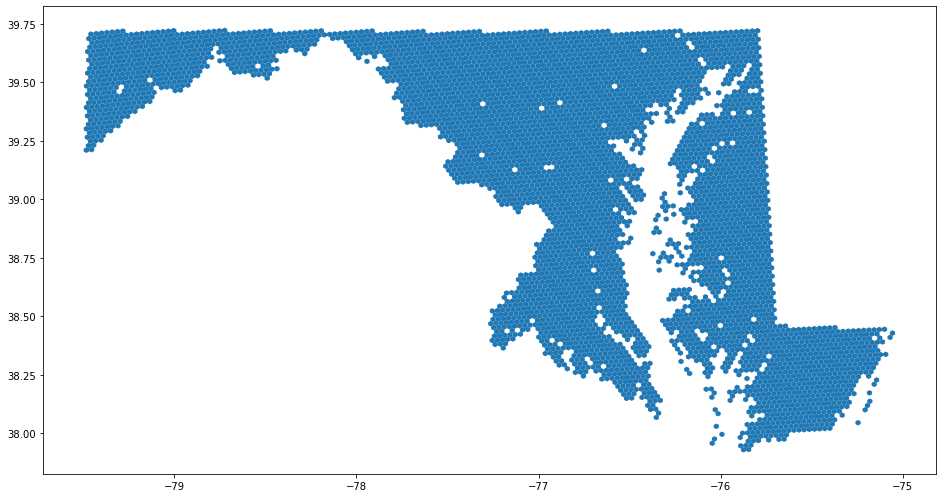

In [5]:
# H3FY TAKES A LONG TIME TO RUN ON LOW PERFORMANCE MACHINES, BEWARE
# md_dissolve = gpd.read_file(r"F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\source\md_dissolved.geojson")
# md_hex = h3fy(md_dissolve, resolution=7)
# md_hex.to_file(driver = 'ESRI Shapefile', filename='md_hex_bins_new.shp')
# Test plot
md_hex.plot(figsize=(16,12))

In [ ]:
# Need to join points to hex bins, then avg the pct_changed field to continue on with autocorrelation
# Supposedly this is the field of the whole tract ID ----> ['CT2010']
hex_join = gpd.sjoin(geo_processed, md_hex, how="inner", op="within")

In [ ]:
# w = sw.Queen.from_dataframe(md_tracts)

# m_pct_change = Moran(geo_processed['value.change'], w)
# print(m_pct_change.I, m_pct_change.p_sim)
# geo_processed.shape

## Geocoding

In [2]:
import pprint
from opencage.geocoder import OpenCageGeocode
keys = ["fc354e502182441aad194782b3a03043",
        "5b20e7f37a124ec2a404cae09f769a41",
        "dd24a3d5426c4e1db7b59066c2803900"]
# geoCoder = OpenCageGeocode(keys[])
geoCoder = OpenCageGeocode("fc354e502182441aad194782b3a03043")
# Read in data
df_to_geoloc = gpd.read_file(r"maryland_tax_valuations\data\processed\appeals_rvals_matched.csv")

In [3]:
mask = df_to_geoloc['match_address'] == 'NA' # 3724 addresses unsuccessfully geocoded
mask.value_counts()

False    54576
True      3724
Name: match_address, dtype: int64

In [4]:
# Subset original dataframe by the mask
unpro_filter = df_to_geoloc[mask]
unpro_filter

,field_1,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,site.address,x,address_correct,address_r1,r2_address,right_match,match_address,lat,long,match_type,state_fips,county_fips,census_tract,census_block,multi,exact,address_type,geometry
0,1,Allegany,0101099973,21502,2016,15400,12400,-3000,0 S OLDTOWN RD CUMBERLAND,,0 S OLDTOWN RD CUMBERLAND MD,"0, OLDTOWN RD S, CUMBERLAND, MD",0 S OLDTOWN RDS CUMBERLAND MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,None
1,2,Allegany,0116005096,21502,2016,240600,228500,-12100,0 OLDTOWN RD CUMBERLAND,,0 OLDTOWN RD CUMBERLAND MD,"0, OLDTOWN RD, CUMBERLAND, MD",0 OLDTOWN RD CUMBERLAND MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,None
4,5,Allegany,0116018538,21502,2016,285500,253100,-32400,14210 HUCKLEBERRY LN CUMBERLAND,,14210 HUCKLEBERRY LN CUMBERLAND MD,"14210, HUCKLEBERRY LN, CUMBERLAND, MD",14210 HUCKLEBERRY LN CUMBERLAND MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,None
17,18,Allegany,0129014892,21502,2016,100700,86300,-14400,26 JENSEN WAY LAVALE,,26 JENSEN WAY LAVALE MD,"26, JENSEN WAY, LAVALE, MD",26 JENSEN WAY LAVALE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,None
19,20,Allegany,0129023832,21502,2016,55500,55500,0,434 CARR DR LAVALE,,434 CARR DR LAVALE MD,"434, CARR DR, LAVALE, MD",434 CARR DR LAVALE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58294,58295,Worcester,2407003986,21863,2020,61300,61300,0,1926 OLD FURNACE RD SNOW HILL,,1926 OLD FURNACE RD SNOW HILL MD,"1926, OLD FURNACE RD, SNOW HILL, MD",1926 OLD FURNACE RD SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,None
58295,58296,Worcester,2407004001,21863,2020,24800,24800,0,0 OLD FURNACE RD SNOW HILL,,0 OLD FURNACE RD SNOW HILL MD,"0, OLD FURNACE RD, SNOW HILL, MD",0 OLD FURNACE RD SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,None
58296,58297,Worcester,2407004907,21863,2020,77900,77900,0,5539 WHITESBURG RD WEST OF SNOW HILL,,5539 WHITESBURG RD WEST OF SNOW HILL MD,"5539, WHITESBURG RD, WEST OF SNOW HILL, MD",5539 WHITESBURG RD WEST OF SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,None
58297,58298,Worcester,2407006349,21863,2020,283700,283700,0,0 WHITESBURG RD WEST OF SNOW HILL,,0 WHITESBURG RD WEST OF SNOW HILL MD,"0, WHITESBURG RD, WEST OF SNOW HILL, MD",0 WHITESBURG RD WEST OF SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,None


In [5]:
len(unpro_filter)

3724

## Retry the geocoding here

## Query 1

In [6]:
# Subsetting first query
pro1 = unpro_filter[:2300]

addresses = pro1["address_correct"].values.tolist()
latitudes = []
longitudes = []

# Geocoding query 1
for address in addresses:
    result = geoCoder.geocode(address)
    if result and len(result):
        longitudes.append(result[0]["geometry"]["lng"])
        latitudes.append(result[0]["geometry"]["lat"])
    else:
        longitudes.append(None)
        latitudes.append(None)

In [7]:
pro1['geometry'] = gpd.points_from_xy(longitudes, latitudes)
pro1

,field_1,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,site.address,x,address_correct,address_r1,r2_address,right_match,match_address,lat,long,match_type,state_fips,county_fips,census_tract,census_block,multi,exact,address_type,geometry
0,1,Allegany,0101099973,21502,2016,15400,12400,-3000,0 S OLDTOWN RD CUMBERLAND,,0 S OLDTOWN RD CUMBERLAND MD,"0, OLDTOWN RD S, CUMBERLAND, MD",0 S OLDTOWN RDS CUMBERLAND MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.63973 -78.76154)
1,2,Allegany,0116005096,21502,2016,240600,228500,-12100,0 OLDTOWN RD CUMBERLAND,,0 OLDTOWN RD CUMBERLAND MD,"0, OLDTOWN RD, CUMBERLAND, MD",0 OLDTOWN RD CUMBERLAND MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.63751 -78.74934)
4,5,Allegany,0116018538,21502,2016,285500,253100,-32400,14210 HUCKLEBERRY LN CUMBERLAND,,14210 HUCKLEBERRY LN CUMBERLAND MD,"14210, HUCKLEBERRY LN, CUMBERLAND, MD",14210 HUCKLEBERRY LN CUMBERLAND MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.56397 -78.69816)
17,18,Allegany,0129014892,21502,2016,100700,86300,-14400,26 JENSEN WAY LAVALE,,26 JENSEN WAY LAVALE MD,"26, JENSEN WAY, LAVALE, MD",26 JENSEN WAY LAVALE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.64498 -78.82337)
19,20,Allegany,0129023832,21502,2016,55500,55500,0,434 CARR DR LAVALE,,434 CARR DR LAVALE MD,"434, CARR DR, LAVALE, MD",434 CARR DR LAVALE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.64693 -78.82694)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33302,33303,Montgomery,160403592972,20850,2018,332900,332900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.08264 -77.15111)
33303,33304,Montgomery,160403592994,20850,2018,382900,382900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.08264 -77.15111)
33304,33305,Montgomery,160403593032,20850,2018,332900,332900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.08264 -77.15111)
33305,33306,Montgomery,160403593065,20850,2018,322900,322900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.08264 -77.15111)


In [74]:
# pro1['geometry'] = gpd.points_from_xy(pro1['geometry'].y, pro1['geometry'].x)
pro2['geometry'] = gpd.points_from_xy(pro2['geometry'].y, pro2['geometry'].x)

,field_1,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,site.address,x,address_correct,address_r1,r2_address,right_match,match_address,lat,long,match_type,state_fips,county_fips,census_tract,census_block,multi,exact,address_type,geometry
33307,33308,Montgomery,160403593112,20850,2018,292900,292900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (-77.15111 39.08264)
33308,33309,Montgomery,160403593134,20850,2018,292900,292900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (-77.15111 39.08264)
33309,33310,Montgomery,160403593203,20850,2018,292900,292900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (-77.15111 39.08264)
33310,33311,Montgomery,160403593247,20850,2018,292900,292900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (-77.15111 39.08264)
33311,33312,Montgomery,160403593260,20850,2018,382900,382900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (-77.15111 39.08264)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58294,58295,Worcester,2407003986,21863,2020,61300,61300,0,1926 OLD FURNACE RD SNOW HILL,,1926 OLD FURNACE RD SNOW HILL MD,"1926, OLD FURNACE RD, SNOW HILL, MD",1926 OLD FURNACE RD SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (-75.49114 38.20224)
58295,58296,Worcester,2407004001,21863,2020,24800,24800,0,0 OLD FURNACE RD SNOW HILL,,0 OLD FURNACE RD SNOW HILL MD,"0, OLD FURNACE RD, SNOW HILL, MD",0 OLD FURNACE RD SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (-75.49114 38.20224)
58296,58297,Worcester,2407004907,21863,2020,77900,77900,0,5539 WHITESBURG RD WEST OF SNOW HILL,,5539 WHITESBURG RD WEST OF SNOW HILL MD,"5539, WHITESBURG RD, WEST OF SNOW HILL, MD",5539 WHITESBURG RD WEST OF SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (-75.53639 38.18284)
58297,58298,Worcester,2407006349,21863,2020,283700,283700,0,0 WHITESBURG RD WEST OF SNOW HILL,,0 WHITESBURG RD WEST OF SNOW HILL MD,"0, WHITESBURG RD, WEST OF SNOW HILL, MD",0 WHITESBURG RD WEST OF SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (-75.53639 38.18284)


In [73]:
# Save work
pro1.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded1.shp')
pro1.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded1.geojson', driver='GeoJSON')

## Query 2

In [49]:
# Subsetting second query
pro2 = unpro_filter[2300:]

addresses = pro2["address_correct"].values.tolist()
latitudes = []
longitudes = []

# Geocoding query 2
for address in addresses:
    result = geoCoder.geocode(address)
    if result and len(result):
        longitudes.append(result[0]["geometry"]["lng"])
        latitudes.append(result[0]["geometry"]["lat"])
    else:
        longitudes.append(None)
        latitudes.append(None)

In [50]:
pro2['geometry'] = gpd.points_from_xy(longitudes, latitudes)
pro2

,field_1,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,site.address,x,address_correct,address_r1,r2_address,right_match,match_address,lat,long,match_type,state_fips,county_fips,census_tract,census_block,multi,exact,address_type,geometry
33307,33308,Montgomery,160403593112,20850,2018,292900,292900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.08264 -77.15111)
33308,33309,Montgomery,160403593134,20850,2018,292900,292900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.08264 -77.15111)
33309,33310,Montgomery,160403593203,20850,2018,292900,292900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.08264 -77.15111)
33310,33311,Montgomery,160403593247,20850,2018,292900,292900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.08264 -77.15111)
33311,33312,Montgomery,160403593260,20850,2018,382900,382900,0,38 MARYLAND AVE ROCKVILLE,,38 MARYLAND AVE ROCKVILLE MD,"38, MARYLAND AVE, ROCKVILLE, MD",38 MARYLAND AVE ROCKVILLE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (39.08264 -77.15111)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58294,58295,Worcester,2407003986,21863,2020,61300,61300,0,1926 OLD FURNACE RD SNOW HILL,,1926 OLD FURNACE RD SNOW HILL MD,"1926, OLD FURNACE RD, SNOW HILL, MD",1926 OLD FURNACE RD SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (38.20224 -75.49114)
58295,58296,Worcester,2407004001,21863,2020,24800,24800,0,0 OLD FURNACE RD SNOW HILL,,0 OLD FURNACE RD SNOW HILL MD,"0, OLD FURNACE RD, SNOW HILL, MD",0 OLD FURNACE RD SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (38.20224 -75.49114)
58296,58297,Worcester,2407004907,21863,2020,77900,77900,0,5539 WHITESBURG RD WEST OF SNOW HILL,,5539 WHITESBURG RD WEST OF SNOW HILL MD,"5539, WHITESBURG RD, WEST OF SNOW HILL, MD",5539 WHITESBURG RD WEST OF SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (38.18284 -75.53639)
58297,58298,Worcester,2407006349,21863,2020,283700,283700,0,0 WHITESBURG RD WEST OF SNOW HILL,,0 WHITESBURG RD WEST OF SNOW HILL MD,"0, WHITESBURG RD, WEST OF SNOW HILL, MD",0 WHITESBURG RD WEST OF SNOW HILL MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,POINT (38.18284 -75.53639)


In [75]:
# Save work
pro2.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded2.shp')
pro2.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded2.geojson', driver='GeoJSON')

## FINAL UPDATES

In [76]:
unpro_filter.update(pro1)
unpro_filter.update(pro2)

unpro_filter.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded_subset_final.shp')
unpro_filter.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded_subset_final.geojson', driver='GeoJSON')

In [80]:
final_geo_df = gpd.GeoDataFrame(pd.concat([geo_processed, unpro_filter], ignore_index=True))

final_geo_df.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded_appraisal_FINAL.shp')
final_geo_df.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded_appraisal_FINAL.geojson', driver='GeoJSON')

## SPATIAL JOINS

<AxesSubplot:>

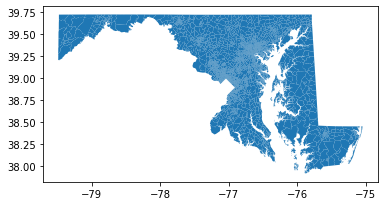

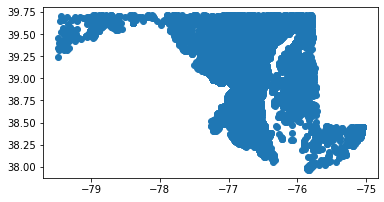

In [29]:
md_blocks = gpd.read_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\source\MD_blck_grp_2019.shp')
md_blocks = md_blocks.to_crs(epsg=4326)
pro1 = pro1.set_crs(epsg=4326)
md_blocks.plot()
geo_processed.plot()

In [116]:
blocks_appraisal_joint_df = gpd.sjoin(final_geo_df, md_blocks, op='intersects')
blocks_appraisal_joint_df

,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,site.address,x,address_correct,address_r1,r2_address,right_match,match_address,match_type,state_fips,county_fips,census_tract,census_block,multi,exact,address_type,num_appeals,pct_change,type_change,geometry,field_1,lat,long,index_right,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area
0,Allegany,0116009105,21502,2016,171300,163700,-7600,12501 GOLDENS AVE CUMBERLAND,,12501 GOLDENS AVE CUMBERLAND MD,"12501, GOLDENS AVE, CUMBERLAND, MD",12501 GOLDENS AVE CUMBERLAND MD,r0[0-9],12501 GOLDENS AVE CUMBERLAND,Non_Exact,24,001,000200,3010,1,False,r0[0-9],1.0,4.4,Decrease,POINT (-78.73335 39.60901),NaN,NaN,NaN,5,G24000100002003,24,001,000200,3,240010002003,Block Group 3,G5030,S,18001658.0,1420738.0,+39.6029095,-078.7351281,29461.455500,1.942240e+07
1,Allegany,0116009784,21502,2016,115700,55500,-60200,12301 PINEY FLATS RD CUMBERLAND,,12301 PINEY FLATS RD CUMBERLAND MD,"12301, PINEY FLATS RD, CUMBERLAND, MD",12301 PINEY FLATS RD CUMBERLAND MD,r0[0-9],12301 PINEY FLATS RD CUMBERLAND,Non_Exact,24,001,000200,1025,1,False,r0[0-9],1.0,52.0,Decrease,POINT (-78.69448 39.62848),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
45,Allegany,0116012343,21555,2016,72600,72600,0,16501 CRESAP MILL RD OLDTOWN,,16501 CRESAP MILL RD OLDTOWN MD,"16501, CRESAP MILL RD, OLDTOWN, MD",16501 CRESAP MILL RD OLDTOWN MD,r0[0-9],16501 CRESAP MILL RD OLDTOWN,Non_Exact,24,001,000200,1010,1,False,r0[0-9],2.0,-0.0,None,POINT (-78.65560 39.57220),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
33453,Allegany,0116003441,21502,2019,551800,541300,-10500,14600 WILLIAMS RD CUMBERLAND,,14600 WILLIAMS RD CUMBERLAND MD,"14600, WILLIAMS RD, CUMBERLAND, MD",14600 WILLIAMS RD CUMBERLAND MD,r0[0-9],14600 WILLIAMS RD CUMBERLAND,Non_Exact,24,001,000200,1025,1,False,r0[0-9],1.0,1.9,Decrease,POINT (-78.69367 39.63498),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
33454,Allegany,0116005150,21502,2019,90800,72500,-18300,14412 MOORES HOLLOW RD CUMBERLAND,,14412 MOORES HOLLOW RD CUMBERLAND MD,"14412, MOORES HOLLOW RD, CUMBERLAND, MD",14412 MOORES HOLLOW RD CUMBERLAND MD,r0[0-9],14412 MOORES HOLLOW RD CUMBERLAND,Non_Exact,24,001,000200,1025,1,False,r0[0-9],1.0,20.2,Decrease,POINT (-78.71485 39.60206),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57322,Worcester,2403167666,21811,2019,331800,331800,0,1206 POINTS REACH OCEAN PINES MD,,1206 POINTS REACH OCEAN PINES MD MD,"1206, POINTS REACH, OCEAN PINES MD, MD",1206 POINTS REACH OCEAN PINES MD MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NaN,NaN,NaN,POINT (-76.85617 38.87147),46879,NA,NA,2661,G24003308022044,24,033,802204,4,240338022044,Block Group 4,G5030,S,4293226.0,1210.0,+38.8758266,-076.8541466,10238.287848,4.294438e+06
57712,Baltimore City,0326176320E089,21224,2020,353800,353800,0,112 S NEWKIRK ST BALTIMORE,,112 S NEWKIRK ST BALTIMORE MD,"112, NEWKIRK ST S, BALTIMORE, MD",112 S NEWKIRK STS BALTIMORE MD,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NaN,NaN,NaN,POINT (-76.55538 39.26537),50657,NA,NA,3719,G24051002606056,24,510,260605,6,245102606056,Block Group 6,G5030,S,8428004.0,7137768.0,+39.2571476,-076.5473462,30686.341620,8.459491e+06
57992,Montgomery,161301238526,20902,2020,257500,257500,0,11926 VALLEYWOOD DR SILVER SPRING,,11926 VALLEYWOOD DR SILVER SPRING MD,"11926, VALLEYWOOD DR, SILVER SPRING, MD",11926 VALLEYWOOD

<AxesSubplot:>

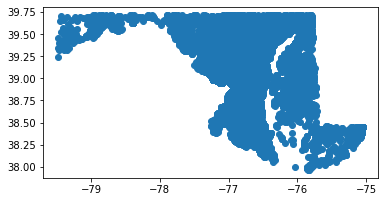

In [108]:
blocks_appraisal_joint_df.plot()

In [83]:
blocks_appraisal_joint_df.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded_sjoined_appraisal.shp')
blocks_appraisal_joint_df.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded_sjoined_appraisal.geojson', driver='GeoJSON')

## TEST GEOCODING

In [127]:
# Checking work
# blocks_appraisal_joint_df.loc[blocks_appraisal_joint_df['geometry'] == 'NA']
blocks_appraisal_joint_df['census_tract'] = blocks_appraisal_joint_df['census_tract'].replace("NA", -999)
blocks_appraisal_joint_df['census_tract'] = pd.to_numeric(blocks_appraisal_joint_df['census_tract'])
blocks_appraisal_joint_df.head(50)

,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,site.address,x,address_correct,address_r1,r2_address,right_match,match_address,match_type,state_fips,county_fips,census_tract,census_block,multi,exact,address_type,num_appeals,pct_change,type_change,geometry,field_1,lat,long,index_right,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area
0,Allegany,0116009105,21502,2016,171300,163700,-7600,12501 GOLDENS AVE CUMBERLAND,,12501 GOLDENS AVE CUMBERLAND MD,"12501, GOLDENS AVE, CUMBERLAND, MD",12501 GOLDENS AVE CUMBERLAND MD,r0[0-9],12501 GOLDENS AVE CUMBERLAND,Non_Exact,24,001,200,3010,1,False,r0[0-9],1.0,4.4,Decrease,POINT (-78.73335 39.60901),NaN,NaN,NaN,5,G24000100002003,24,001,000200,3,240010002003,Block Group 3,G5030,S,18001658.0,1420738.0,+39.6029095,-078.7351281,29461.455500,1.942240e+07
1,Allegany,0116009784,21502,2016,115700,55500,-60200,12301 PINEY FLATS RD CUMBERLAND,,12301 PINEY FLATS RD CUMBERLAND MD,"12301, PINEY FLATS RD, CUMBERLAND, MD",12301 PINEY FLATS RD CUMBERLAND MD,r0[0-9],12301 PINEY FLATS RD CUMBERLAND,Non_Exact,24,001,200,1025,1,False,r0[0-9],1.0,52.0,Decrease,POINT (-78.69448 39.62848),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
45,Allegany,0116012343,21555,2016,72600,72600,0,16501 CRESAP MILL RD OLDTOWN,,16501 CRESAP MILL RD OLDTOWN MD,"16501, CRESAP MILL RD, OLDTOWN, MD",16501 CRESAP MILL RD OLDTOWN MD,r0[0-9],16501 CRESAP MILL RD OLDTOWN,Non_Exact,24,001,200,1010,1,False,r0[0-9],2.0,-0.0,None,POINT (-78.65560 39.57220),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
33453,Allegany,0116003441,21502,2019,551800,541300,-10500,14600 WILLIAMS RD CUMBERLAND,,14600 WILLIAMS RD CUMBERLAND MD,"14600, WILLIAMS RD, CUMBERLAND, MD",14600 WILLIAMS RD CUMBERLAND MD,r0[0-9],14600 WILLIAMS RD CUMBERLAND,Non_Exact,24,001,200,1025,1,False,r0[0-9],1.0,1.9,Decrease,POINT (-78.69367 39.63498),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
33454,Allegany,0116005150,21502,2019,90800,72500,-18300,14412 MOORES HOLLOW RD CUMBERLAND,,14412 MOORES HOLLOW RD CUMBERLAND MD,"14412, MOORES HOLLOW RD, CUMBERLAND, MD",14412 MOORES HOLLOW RD CUMBERLAND MD,r0[0-9],14412 MOORES HOLLOW RD CUMBERLAND,Non_Exact,24,001,200,1025,1,False,r0[0-9],1.0,20.2,Decrease,POINT (-78.71485 39.60206),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
33455,Allegany,0116009814,21502,2019,34500,25100,-9400,12600 PINEY FLATS RD CUMBERLAND,,12600 PINEY FLATS RD CUMBERLAND MD,"12600, PINEY FLATS RD, CUMBERLAND, MD",12600 PINEY FLATS RD CUMBERLAND MD,r0_a,12600 PINEY FLATS RD CUMBERLAND MD,Non_Exact,24,001,200,1025,1,False,r0_a,1.0,27.2,Decrease,POINT (-78.69620 39.62511),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
33456,Allegany,0116012653,21502,2019,99900,99900,0,15912 BRICE HOLLOW RD CUMBERLAND,,15912 BRICE HOLLOW RD CUMBERLAND MD,"15912, BRICE HOLLOW RD, CUMBERLAND, MD",15912 BRICE HOLLOW RD CUMBERLAND MD,r0[0-9],15912 BRICE HOLLOW RD CUMBERLAND,Non_Exact,24,001,200,1001,1,False,r0[0-9],1.0,-0.0,None,POINT (-78.70060 39.57898),NaN,NaN,NaN,3,G24000100002001,24,001,000200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07
33457,Allegany,0116014885,21502,2019,439300,406500,-32800,15710 COLLIER RUN RD CUMBERLAND,,15710 COLLIER RUN RD CUMBERLAND MD,"15710, COLLIER RUN RD, CUMBERLAND, MD",15710 COLLIER RUN RD CUMBERLAND MD,r0[0-9],15710 COLLIER RUN RD CUMBERLAND,Non_Exact,24,001,200,1002,1,Fa

In [99]:
census_data = pd.read_csv(r"F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\source\nhgis-blck_grp-edit.csv")
census_data

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,census_tract,BLKGRPA,CONCITA,AIANHHA,RES_ONLYA,TRUSTA,AIHHTLI,AITS,ANRCA,CBSAA,CSAA,METDIVA,MEMI,NECTAA,CNECTAA,NECTADIVA,UAA,CDCURRA,SLDUA,SLDLA,ZCTA5A,SUBMCDA,SDELMA,SDSECA,SDUNIA,UR,PCI,PUMA5A,GEOID,BTTRA,BTBGA,NAME_E,ALUBE001,ALUCE001,ALUCE002,ALUCE003,ALUCE004,ALUCE005,ALUCE006,...,ALW0M012,ALW0M013,ALW0M014,ALW0M015,ALW0M016,ALW0M017,ALW1M001,ALX5M001,ALZJM001,ALZWM001,ALZWM002,ALZWM003,ALZWM004,ALZWM005,ALZWM006,ALZWM007,ALZWM008,ALZWM009,ALZWM010,ALZ0M001,ALZ0M002,ALZ0M003,AL1FM001,AL1FM002,AL1FM003,AL1FM004,AL1FM005,AL1FM006,AL1FM007,AL1FM008,AL1FM009,AL1FM010,AL1FM011,AL1FM012,AL1FM013,AL1FM014,AL1FM015,AL1FM016,AL1FM017,AL1FM018,AL1FM019,AL1FM020,AL1FM021,AL1FM022,AL1FM023,AL1FM024,AL1FM025,AL1FM026,AL1FM027,AL1HM001
0,G24000100001001,2015-2019,MD,NaN,NaN,Maryland,24,Allegany County,1,NaN,NaN,100,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000US240010001001,NaN,NaN,"Block Group 1, Census Tract 1, Allegany County...",584,584,570,0,0,0,0,...,37,30,15,12,20,12,17860.0,4953.0,98,70,67,12,12,12,12,25,12,12,12,0.44,0.55,NaN,65,12,12,12,12,12,12,12,12,19,12,12,12,15,35,25,12,20,40,30,23,19,12,12,12,12,12,45036.0
1,G24000100001002,2015-2019,MD,NaN,NaN,Maryland,24,Allegany County,1,NaN,NaN,100,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000US240010001002,NaN,NaN,"Block Group 2, Census Tract 1, Allegany County...",1858,1858,1829,13,0,12,0,...,53,83,22,26,9,23,10113.0,5301.0,108,104,104,12,12,12,12,12,12,12,12,0.25,0.27,0.74,103,12,12,12,12,12,12,42,51,12,38,31,12,33,35,30,54,37,72,30,20,19,25,17,12,12,13,15700.0
2,G24000100001003,2015-2019,MD,NaN,NaN,Maryland,24,Allegany County,1,NaN,NaN,100,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000US240010001003,NaN,NaN,"Block Group 3, Census Tract 1, Allegany County...",1139,1139,1127,0,0,7,0,...,44,38,27,22,31,22,16530.0,4879.0,106,78,78,12,12,12,12,12,8,12,8,0.28,0.27,1.11,68,12,12,12,14,12,19,12,15,19,16,21,24,12,34,53,36,18,41,28,18,17,12,12,12,12,12,16283.0
3,G24000100002001,2015-2019,MD,NaN,NaN,Maryland,24,Allegany County,1,NaN,NaN,200,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000US240010002001,NaN,NaN,"Block Group 1, Census Tract 2, Allegany County...",665,665,623,4,0,15,0,...,34,47,27,18,11,16,19213.0,29570.0,82,67,67,12,12,12,12,12,12,12,12,0.40,0.45,0.91,60,12,12,12,12,12,12,38,13,16,12,12,29,12,25,19,33,12,21,17,38,12,12,12,12,12,12,43222.0
4,G24000100002002,2015-2019,MD,NaN,NaN,Maryland,24,Allegany County,1,NaN,NaN,200,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000US240010002002,NaN,NaN,"Block Group 2, Census Tract 2, Allegany County...",1115,1115,1060,0,0,46,9,...,32,49,41,13,24,12,32498.0,3818.0,82,73,73,12,12,12,12,12,12,12,12,0.27,0.35,0.55,68,12,12,12,12,12,12,12,12,17,35,40,30,29,34,19,36,14,29,21,23,12,12,12,12,12,12,18326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,G24051002804042,2015-2019,MD,NaN,NaN,Maryland,24,Baltimore city,510,NaN,NaN,280404,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000US245102804042,NaN,NaN,"Block Group 2, Census Tract 2804.04, Baltimore...",524,524,31,467,18,0,0,...,62,64,29,7,17,12,18574.0,10331.0,75,85,9,82,27,12,12,12,13,12,13,0.77,1.32,0.59,53,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,41,12,31,16,12,20,12,

In [128]:
fully_merged_data = gpd.GeoDataFrame(blocks_appraisal_joint_df.merge(census_data, on='census_tract'))
fully_merged_data

,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,site.address,x,address_correct,address_r1,r2_address,right_match,match_address,match_type,state_fips,county_fips,census_tract,census_block,multi,exact,address_type,num_appeals,pct_change,type_change,geometry,field_1,lat,long,index_right,GISJOIN_x,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,GISJOIN_y,YEAR,STUSAB,REGIONA,DIVISIONA,...,ALW0M012,ALW0M013,ALW0M014,ALW0M015,ALW0M016,ALW0M017,ALW1M001,ALX5M001,ALZJM001,ALZWM001,ALZWM002,ALZWM003,ALZWM004,ALZWM005,ALZWM006,ALZWM007,ALZWM008,ALZWM009,ALZWM010,ALZ0M001,ALZ0M002,ALZ0M003,AL1FM001,AL1FM002,AL1FM003,AL1FM004,AL1FM005,AL1FM006,AL1FM007,AL1FM008,AL1FM009,AL1FM010,AL1FM011,AL1FM012,AL1FM013,AL1FM014,AL1FM015,AL1FM016,AL1FM017,AL1FM018,AL1FM019,AL1FM020,AL1FM021,AL1FM022,AL1FM023,AL1FM024,AL1FM025,AL1FM026,AL1FM027,AL1HM001
0,Allegany,0116009105,21502,2016,171300,163700,-7600,12501 GOLDENS AVE CUMBERLAND,,12501 GOLDENS AVE CUMBERLAND MD,"12501, GOLDENS AVE, CUMBERLAND, MD",12501 GOLDENS AVE CUMBERLAND MD,r0[0-9],12501 GOLDENS AVE CUMBERLAND,Non_Exact,24,001,200,3010,1,False,r0[0-9],1.0,4.4,Decrease,POINT (-78.73335 39.60901),NaN,NaN,NaN,5,G24000100002003,24,001,000200,3,240010002003,Block Group 3,G5030,S,18001658.0,1420738.0,+39.6029095,-078.7351281,29461.455500,1.942240e+07,G24000100002001,2015-2019,MD,NaN,NaN,...,34,47,27,18,11,16,19213.0,29570.0,82,67,67,12,12,12,12,12,12,12,12,0.40,0.45,0.91,60,12,12,12,12,12,12,38,13,16,12,12,29,12,25,19,33,12,21,17,38,12,12,12,12,12,12,43222.0
1,Allegany,0116009105,21502,2016,171300,163700,-7600,12501 GOLDENS AVE CUMBERLAND,,12501 GOLDENS AVE CUMBERLAND MD,"12501, GOLDENS AVE, CUMBERLAND, MD",12501 GOLDENS AVE CUMBERLAND MD,r0[0-9],12501 GOLDENS AVE CUMBERLAND,Non_Exact,24,001,200,3010,1,False,r0[0-9],1.0,4.4,Decrease,POINT (-78.73335 39.60901),NaN,NaN,NaN,5,G24000100002003,24,001,000200,3,240010002003,Block Group 3,G5030,S,18001658.0,1420738.0,+39.6029095,-078.7351281,29461.455500,1.942240e+07,G24000100002002,2015-2019,MD,NaN,NaN,...,32,49,41,13,24,12,32498.0,3818.0,82,73,73,12,12,12,12,12,12,12,12,0.27,0.35,0.55,68,12,12,12,12,12,12,12,12,17,35,40,30,29,34,19,36,14,29,21,23,12,12,12,12,12,12,18326.0
2,Allegany,0116009105,21502,2016,171300,163700,-7600,12501 GOLDENS AVE CUMBERLAND,,12501 GOLDENS AVE CUMBERLAND MD,"12501, GOLDENS AVE, CUMBERLAND, MD",12501 GOLDENS AVE CUMBERLAND MD,r0[0-9],12501 GOLDENS AVE CUMBERLAND,Non_Exact,24,001,200,3010,1,False,r0[0-9],1.0,4.4,Decrease,POINT (-78.73335 39.60901),NaN,NaN,NaN,5,G24000100002003,24,001,000200,3,240010002003,Block Group 3,G5030,S,18001658.0,1420738.0,+39.6029095,-078.7351281,29461.455500,1.942240e+07,G24000100002003,2015-2019,MD,NaN,NaN,...,46,32,26,12,18,12,13457.0,3107.0,61,63,63,12,12,12,12,12,12,12,12,0.58,0.72,0.83,60,12,14,12,12,10,12,17,10,12,17,12,33,20,14,28,35,12,30,24,20,12,23,12,12,12,12,23758.0
3,Allegany,0116009105,21502,2016,171300,163700,-7600,12501 GOLDENS AVE CUMBERLAND,,12501 GOLDENS AVE CUMBERLAND MD,"12501, GOLDENS AVE, CUMBERLAND, MD",12501 GOLDENS AVE CUMBERLAND MD,r0[0-9],12501 GOLDENS AVE CUMBERLAND,Non_Exact,24,001,200,3010,1,False,r0[0-9],1.0,4.4,Decrease,POINT (-78.73335 39.60901),NaN,NaN,NaN,5,G24000100002003,24,001,000200,3,240010002003,Block Group 3,G5030,S,18001658.0,1420738.0,+39.6029095,-078.7351281,29461.455500,1.942240e+07,G24002300002001,2015-2019,MD,NaN,NaN,...,42,43,42,43,6,22,15681.0,6084.0,102,90,88,12,8,12,12,12,3,12,3,0.37,0.48,0.46,81,12,12,12,12,11,12,7,12,11,19,3,21,27,53,25,28,36,41,28,18,16,12,24,20,12,15,24558.0
4,Allegany,0116009105,21502,2016,171300,163700,-7600,12501 GOLDENS AVE CUMBERLAND,,12501 GOLDENS AVE CUMBERLAND MD,"12501, GOLDENS AVE, CUMBERLAND, MD",12501 GOLDENS AVE CUMBERLAND MD,r0[0-9],12501 GOLDENS AVE CUMBERLAND,Non_Exact,24,001,200,3010,1,False,r0[0-9],1.0,4.4,Decrease,POINT (-78.73335 39.60901),NaN,NaN,NaN,5,G24000100002003,24,001,000200,3,240010002003,Block Group 3

In [135]:
# fully_merged_data.loc[fully_merged_data['census_tract'] == -999]
fully_merged_data['census_tract'].value_counts()

260401    3477
100       3094
260302    2232
60200     1970
702402    1842
          ... 
408400       1
701601       1
850201       1
700830       1
801801       1
Name: census_tract, Length: 1220, dtype: int64

In [137]:
fully_merged_data.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\fully_merged_data_FINAL.geojson', driver='GeoJSON')
fully_merged_data.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\fully_merged_data_FINAL.shp')

In [ ]:
fully_merged_data.plot()

In [144]:
inp = np.array([1.2, 5.1, 2.1])
weights = np.array([3.1, 2.1, 8.7])
bias = 3

output = (inp * weights).sum() + bias
output

35.7

In [172]:
tract_counts = fully_merged_data.groupby('census_tract')
counts = tract_counts.count()
counts = counts['county'].reset_index().rename(columns={"county": "count"})
counts['census_tract'].dtype

dtype('int64')

In [180]:
md_blocks['TRACTCE'] = pd.to_numeric(md_blocks['TRACTCE'])
counts_merge = pd.merge(md_blocks, counts, how="left", left_on='TRACTCE', right_on='census_tract')
counts_merge = counts_merge.drop(['census_tract'], axis=1)
counts_merge

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,count
0,G24000100001001,24,001,100,1,240010001001,Block Group 1,G5030,S,114621272.0,2257826.0,+39.6704707,-078.3878895,79292.546845,1.168791e+08,"POLYGON ((-78.34283 39.72226, -78.34273 39.722...",3094.0
1,G24000100001002,24,001,100,2,240010001002,Block Group 2,G5030,S,215159992.0,508136.0,+39.6796402,-078.5461225,71818.111670,2.156681e+08,"POLYGON ((-78.49645 39.60403, -78.49704 39.604...",3094.0
2,G24000100001003,24,001,100,3,240010001003,Block Group 3,G5030,S,156974532.0,5055373.0,+39.5688450,-078.5444290,74433.243094,1.620299e+08,"POLYGON ((-78.45216 39.53796, -78.45223 39.537...",3094.0
3,G24000100002001,24,001,200,1,240010002001,Block Group 1,G5030,S,59872397.0,755914.0,+39.6040484,-078.6694545,40847.450865,6.062833e+07,"POLYGON ((-78.66649 39.64302, -78.66636 39.642...",720.0
4,G24000100002002,24,001,200,2,240010002002,Block Group 2,G5030,S,46634233.0,903548.0,+39.6858145,-078.6757386,38515.709021,4.753778e+07,"POLYGON ((-78.66649 39.64302, -78.66680 39.643...",720.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,G24051002804042,24,510,280404,2,245102804042,Block Group 2,G5030,S,421869.0,0.0,+39.2906503,-076.6933593,3416.736737,4.218689e+05,"POLYGON ((-76.68892 39.28820, -76.68929 39.288...",46.0
3911,G24051002805001,24,510,280500,1,245102805001,Block Group 1,G5030,S,267402.0,0.0,+39.2957788,-076.5971889,2117.870074,2.674019e+05,"POLYGON ((-76.59441 39.29837, -76.59436 39.297...",52.0
3912,G24051002805002,24,510,280500,2,245102805002,Block Group 2,G5030,S,432346.0,0.0,+39.2944496,-076.6068754,3440.740030,4.323451e+05,"POLYGON ((-76.60299 39.29479, -76.60293 39.293...",52.0
3913,G24051002805003,24,510,280500,3,245102805003,Block Group 3,G5030,S,162938.0,0.0,+39.2963293,-076.6025594,1686.120306,1.629382e+05,"POLYGON ((-76.59983 39.29492, -76.60046 39.294...",52.0


<AxesSubplot:>

<Figure size 1080x720 with 0 Axes>

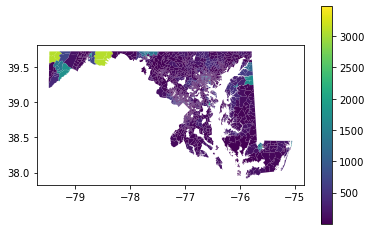

In [186]:
plt.figure(figsize=(15,10))
counts_merge.plot(column='count', legend=True)